<a href="https://colab.research.google.com/github/decoam/ProyekSPK/blob/main/Final_Proyek_3E__2123_Deco_Akbar_Maulana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

# 1. IMPORT LIBRARY


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Setting opsional untuk tampilan
pd.set_option('display.max_columns', None)


# 2. LOAD DATASET


# Karena file dataset.csv sudah muncul di panel kiri (root /content),
# cukup pakai nama filenya saja:
df = pd.read_csv('dataset.csv')      # atau: pd.read_csv('/content/dataset.csv')

print("Ukuran data:", df.shape)
df.head()
df_small = df.sample(8000, random_state=42).reset_index(drop=True)



Ukuran data: (114000, 21)


=== INFO DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  li

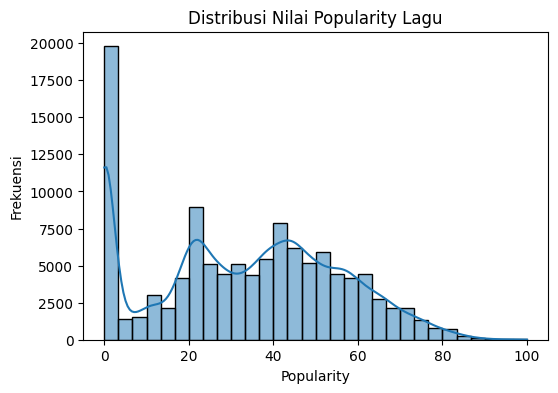

In [6]:

# 3. EDA SEDERHANA (Exploratory Data Analysis)


# Info tipe data
print("=== INFO DATA ===")
print(df.info())

# Cek missing values
print("\n=== MISSING VALUES SETIAP KOLOM ===")
print(df.isna().sum())

# Statistik deskriptif
print("\n=== DESKRIPTIF NUMERIK ===")
print(df.describe())

# Distribusi popularity
plt.figure(figsize=(6,4))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Distribusi Nilai Popularity Lagu')
plt.xlabel('Popularity')
plt.ylabel('Frekuensi')
plt.show()


In [7]:

# 4. MEMBUAT KOLOM TARGET: popular_label (0/1)


# Tambahkan kolom label 0/1 ke df_small
df_small['popular_label'] = (df_small['popularity'] >= 60).astype(int)

print("Distribusi kelas popular_label:")
print(df_small['popular_label'].value_counts())

print("\nPersentase:")
print(df_small['popular_label'].value_counts(normalize=True) * 100)


Distribusi kelas popular_label:
popular_label
0    6959
1    1041
Name: count, dtype: int64

Persentase:
popular_label
0    86.9875
1    13.0125
Name: proportion, dtype: float64


In [15]:
# FIX: pastikan kolom label dibuat lebih awal
df_small['popular_label'] = (df_small['popularity'] >= 60).astype(int)


In [16]:

# 5. PEMILIHAN FITUR & DROP KOLOM YANG TIDAK DIPAKAI


drop_cols = [
    'Unnamed: 0','track_id','artists','album_name',
    'track_name','track_genre','popularity'
]

# Buat salinan dataframe awal
df_model = df_small.copy()

# Drop kolom-kolom yang tidak diperlukan
df_model = df_model.drop(columns=drop_cols, errors='ignore')

print("Kolom setelah dibersihkan:")
print(df_model.columns)

df_model.head()


Kolom setelah dibersihkan:
Index(['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'popular_label'],
      dtype='object')


,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popular_label
0,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,0
1,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,0
2,213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,0
3,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,0
4,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,0


In [17]:
print(df_small.columns)
print(df_model.columns)


Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'popular_label'],
      dtype='object')
Index(['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'popular_label'],
      dtype='object')


In [18]:

# 6. MENENTUKAN FITUR (X) dan LABEL (y)


# FIX: pastikan label ada
if 'popular_label' not in df_model.columns:
    df_model['popular_label'] = (df_model['popularity'] >= 60).astype(int)

# PILIH FITUR
feature_cols = [
    'duration_ms','danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','liveness','valence','tempo'
]

# CEK KEBERADAAN FITUR
for col in feature_cols:
    if col not in df_model.columns:
        print("Kolom hilang:", col)

X = df_model[feature_cols]
y = df_model['popular_label']

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (8000, 10)
Shape y: (8000,)


In [19]:

# 7. SPLIT DATA: TRAIN & TEST


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test :", X_test.shape)
print("Ukuran y_train:", y_train.shape)
print("Ukuran y_test :", y_test.shape)


Ukuran X_train: (6400, 10)
Ukuran X_test : (1600, 10)
Ukuran y_train: (6400,)
Ukuran y_test : (1600,)


In [20]:

# 8. NORMALISASI FITUR (WAJIB UNTUK KNN)


scaler = StandardScaler()

# Fit hanya pada data train
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Contoh sebelum scaling:\n", X_train.iloc[0])
print("\nContoh setelah scaling:\n", X_train_scaled[0])


Contoh sebelum scaling:
 duration_ms         139159.000
danceability             0.814
energy                   0.740
loudness                -5.738
speechiness              0.145
acousticness             0.165
instrumentalness         0.000
liveness                 0.111
valence                  0.700
tempo                  138.069
Name: 2036, dtype: float64

Contoh setelah scaling:
 [-0.9685428   1.43909735  0.38876569  0.50215139  0.55303509 -0.45244989
 -0.49685915 -0.54147207  0.88215627  0.52464808]


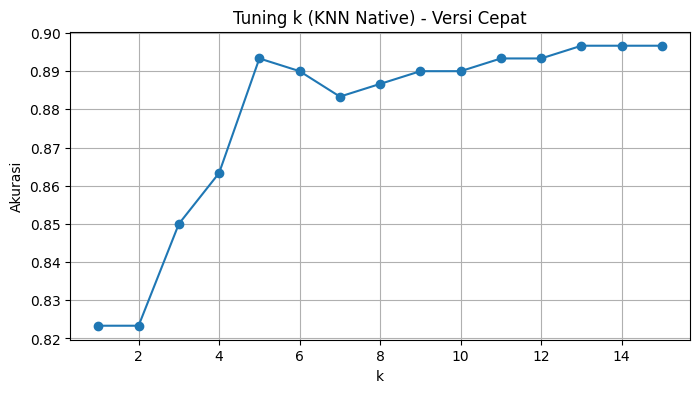

Nilai k terbaik: 13
Akurasi terbaik: 0.8966666666666666


In [21]:

# 9. TUNING HYPERPARAMETER (VERSI CEPAT)


from math import sqrt
from collections import Counter

# --- SUBSET untuk tuning agar cepat ---
X_train_tune = X_train_scaled[:2000]
y_train_tune = y_train.values[:2000]

X_test_tune  = X_test_scaled[:300]
y_test_tune  = y_test.values[:300]

def euclidean_distance(a, b):
    return sqrt(np.sum((a - b)**2))

def predict_one(x, X_train, y_train, k):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(x, X_train[i])
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    k_neighbors = distances[:k]
    labels = [label for (_, label) in k_neighbors]
    return Counter(labels).most_common(1)[0][0]

def predict(X_test, X_train, y_train, k):
    return np.array([predict_one(x, X_train, y_train, k) for x in X_test])

k_values = range(1, 16)
accuracies = []

for k in k_values:
    y_pred_k = predict(X_test_tune, X_train_tune, y_train_tune, k)
    acc = np.sum(y_pred_k == y_test_tune) / len(y_test_tune)
    accuracies.append(acc)

plt.figure(figsize=(8,4))
plt.plot(list(k_values), accuracies, marker='o')
plt.title('Tuning k (KNN Native) - Versi Cepat')
plt.xlabel('k')
plt.ylabel('Akurasi')
plt.grid(True)
plt.show()

best_k = k_values[int(np.argmax(accuracies))]
best_acc = max(accuracies)

print("Nilai k terbaik:", best_k)
print("Akurasi terbaik:", best_acc)


In [22]:

# 10. TRAIN ULANG MODEL KNN DENGAN k TERBAIK (WEIGHTED)


knn_best = KNeighborsClassifier(
    n_neighbors=best_k,
    algorithm='kd_tree',
    weights='distance',   # untuk menangani data imbalanced
    n_jobs=-1
)

knn_best.fit(X_train_scaled, y_train)

y_pred_best = knn_best.predict(X_test_scaled)

print("Model berhasil dilatih dengan k =", best_k)


Model berhasil dilatih dengan k = 13


In [25]:
# Akurasi model akhir
acc = accuracy_score(y_test, y_pred_best)
print(f"Akurasi Model KNN (k={best_k}): {acc:.4f}")


Akurasi Model KNN (k=13): 0.8706


Confusion Matrix:
 [[1385    7]
 [ 200    8]]


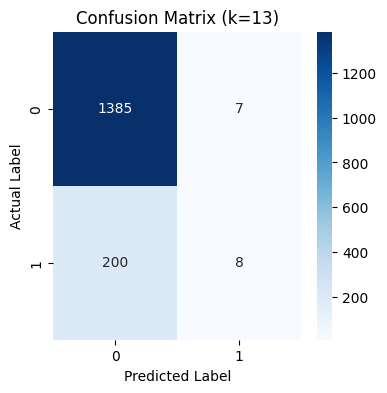

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm)

# Plot heatmap
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (k={best_k})')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()


In [28]:
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_best, target_names=['Tidak Populer', 'Populer']))


Classification Report:

               precision    recall  f1-score   support

Tidak Populer       0.87      0.99      0.93      1392
      Populer       0.53      0.04      0.07       208

     accuracy                           0.87      1600
    macro avg       0.70      0.52      0.50      1600
 weighted avg       0.83      0.87      0.82      1600

